# TM10007 Assignment template

In [25]:
# Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Preprocessing
from sklearn import model_selection

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.model_selection import GridSearchCV, StratifiedKFold 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from scipy.stats import randint

#moeten deze nog even opschonen als alle code erin staat 

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(data)

The number of samples: 115
The number of columns: 494
                  label  PREDICT_original_sf_compactness_avg_2.5D  \
ID                                                                  
Lipo-001_0  liposarcoma                                  0.368434   
Lipo-002_0  liposarcoma                                  0.660571   
Lipo-003_0       lipoma                                  0.365191   
Lipo-004_0  liposarcoma                                  0.372210   
Lipo-005_0       lipoma                                  0.369120   
...                 ...                                       ...   
Lipo-111_0       lipoma                                  0.244813   
Lipo-112_0  liposarcoma                                  0.197353   
Lipo-113_0  liposarcoma                                  0.307562   
Lipo-114_0       lipoma                                  0.577333   
Lipo-115_0  liposarcoma                                  0.635282   

            PREDICT_original_sf_compactness_std_

In [3]:
"""Check for duplicate patients""" 
duplicates = data[data.duplicated(keep=False)]  
data = data.drop_duplicates(keep='first')
print(f"Number of rows after checking for duplicates: {len(data)}")

Number of rows after checking for duplicates: 115


In [4]:
"""Check for missing values"""
data_missing_values = data.replace(' ', np.nan)                   
missing_values = data[data.isnull().any(axis=1)]         

if not missing_values.empty:
    print(f"Missing values; {missing_values}")
else:
    print("No missing values")


No missing values


In [5]:
"""Splitting the data into a test and training dataset: outer cross-validation"""
data_train, data_test = model_selection.train_test_split(data, test_size=0.20, random_state=42)
print(f'The number of samples train: {len(data_train.index)}')
print(f'The number of columns train: {len(data_train.columns)}')
print(f'The number of samples test: {len(data_test.index)}')
print(f'The number of columns test: {len(data_test.columns)}')

The number of samples train: 92
The number of columns train: 494
The number of samples test: 23
The number of columns test: 494


In [6]:
"""Detect and replace outliers"""
from outliers import outlier_detection
data_train, total_outliers = outlier_detection(data_train)
print("\nTotal number of captured outliers in the train data:", total_outliers)

# dit moet dus wellicht nog op basis van de outliers van de train data 
# data_test, total_outliers = outlier_detection(data_test)
# print("\nTotal number of captured outliers in the test data:", total_outliers)

c:\Users\Kools\Documents\AATM1\AAMachineLearning\TM10007_ML_Project_group_9\outliers.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = zscore(data[column])
c:\Users\Kools\Documents\AATM1\AAMachineLearning\TM10007_ML_Project_group_9\outliers.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[24.64053713 24.64053713 24.64053713 24.64053713 24.64053713 24.64053713
 24.64053713 24.64053713]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[outliers,column] = np.clip(data.loc[outliers,column], mean_value - drempel * std_value, mean_value + drempel * std_value)
c:\Users\Kools\Documents\AATM1\AAMachineLearning\TM10007_ML_Project_group_9\outliers.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to cat


Total number of captured outliers in the train data: 676


In [7]:
from prepro_data import processing_data_scaling
#This data is scaled and a variance and correlation threshold are applied
data_scaled, df_label, df_processed= processing_data_scaling(data_train)
print(data_scaled)

                  label         0         1         2         3         4  \
ID                                                                          
Lipo-032_0       lipoma  0.127398 -0.673495 -0.496535 -0.555369 -0.647034   
Lipo-068_0  liposarcoma  2.217498  0.757115 -0.481242  0.275441  1.658510   
Lipo-094_0       lipoma -0.387006 -0.106395 -0.255363  0.114611 -0.278687   
Lipo-110_0       lipoma  0.315505  2.120475  0.246812  0.129628 -0.139890   
Lipo-023_0       lipoma  2.768057  2.239267 -0.577425 -0.150222 -0.321659   
...                 ...       ...       ...       ...       ...       ...   
Lipo-107_0       lipoma -0.125152 -0.079092 -0.648579 -0.778107 -0.835305   
Lipo-015_0  liposarcoma  3.021172  2.595117  3.794122  3.646962  3.151451   
Lipo-093_0       lipoma -1.387498 -1.047455 -0.633165 -0.949705 -0.916270   
Lipo-052_0       lipoma -0.209156 -0.996782 -0.288488  0.453299  0.511219   
Lipo-103_0  liposarcoma  0.760731  0.130363  3.794122  2.378133  0.524284   

In [8]:
from prepro_data import processing_data_pca
#This data is scaled, a variance and correlation threshold are applied, 
# and PCA brought back the number of features to 36
#dit kan er dan miss uit 
data_pca, df_label, df_processed= processing_data_pca(data_train)
print(data_pca)
print(df_label)
print(df_processed)

                  label          0         1         2         3         4  \
ID                                                                           
Lipo-032_0       lipoma  -3.504043 -6.729541  1.790805 -1.733311  2.658756   
Lipo-068_0  liposarcoma   9.056580 -7.772668  4.074350 -2.895457 -0.950597   
Lipo-094_0       lipoma  -0.611499  0.546490 -3.656370  2.394620  1.813870   
Lipo-110_0       lipoma  -4.050309 -4.151106 -0.790247  1.285232 -3.627637   
Lipo-023_0       lipoma   8.782667 -6.771863 -1.338336  1.034992 -2.133264   
...                 ...        ...       ...       ...       ...       ...   
Lipo-107_0       lipoma   1.923888  0.323315 -3.528955  2.717679 -0.127235   
Lipo-015_0  liposarcoma   9.548997 -5.572194 -4.010817 -0.011732 -4.038112   
Lipo-093_0       lipoma -14.521505  0.055029 -0.485778 -1.018744 -1.675438   
Lipo-052_0       lipoma   2.468140  1.617369  0.093805  0.900247  4.150410   
Lipo-103_0  liposarcoma   1.716241 -0.328468  7.402464  2.179075

                   4        10        17        18        28        41  \
ID                                                                       
Lipo-032_0 -0.647034 -0.065218  0.756813  0.008504 -0.070142  1.188105   
Lipo-068_0  1.658510 -0.833348 -0.171544  1.850824 -0.070142  0.407703   
Lipo-094_0 -0.278687  1.183826 -0.790449 -0.517614  0.710126 -0.440107   
Lipo-110_0 -0.139890 -0.962496 -1.718805 -0.417578 -0.070142  1.576124   
Lipo-023_0 -0.321659  1.028971  0.137908  0.814749  0.710126 -0.134410   
...              ...       ...       ...       ...       ...       ...   
Lipo-107_0 -0.835305  1.958281 -0.171544 -0.442040 -0.070142 -0.808324   
Lipo-015_0  3.151451  0.206287  1.685169  1.810936 -0.070142 -0.585665   
Lipo-093_0 -0.916270 -0.826334 -0.480996 -0.646850  1.490394  1.824913   
Lipo-052_0  0.511219  0.886395  0.756813  0.142165  0.710126 -0.468977   
Lipo-103_0  0.524284 -0.387964  2.304074  2.460989 -0.070142  0.437382   

                  53        60       

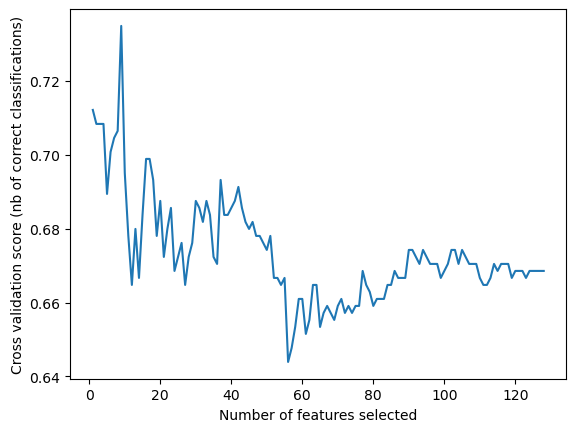

In [9]:
from prepro_data import processing_data_rfecv
# This data is scaled, a variance and correlation threshold are applied,
# RFECV brought back the number of features to 61 (takes a bit longer to run)
data_rf, df_label, df_processed= processing_data_rfecv(data_train)
print(data_rf)
print(data_rf.columns)

In [10]:
"""Support Vector Machine"""
# Split data into features and labels
X = data_rf.drop(data_rf.columns[[0, 1]], axis=1)  # Features
Y = df_label['label']  # Labels

# Set up the parameter grid for GridSearchCV
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.1, 1]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [3, 4, 5], 'gamma': ['scale', 'auto', 0.1, 1], 'coef0': [0.0, 0.1, 0.5]},
]

# Set up the SVM classifier
svm_classifier = SVC(random_state=42, probability=True)  # Enable probability for AUC calculation

# Set up inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=svm_classifier,
    param_grid=param_grid,
    scoring='roc_auc',         # Optimize AUC score
    refit=True,                # Refit best model on full training data
    cv=inner_cv,
    n_jobs=-1,
    verbose=1
)

# Perform the grid search on the training data to find the best hyperparameters
grid_search.fit(X, Y)

# Get the best model (with the best hyperparameters)
best_model_svm = grid_search.best_estimator_

# Make predictions to evaluate performance
y_pred = best_model_svm.predict(X)
y_pred_proba = best_model_svm.predict_proba(X)[:, 1]  # Probability estimates for AUC

# Convert categorical labels to numerical labels (0 or 1)
le = LabelEncoder()
Y = le.fit_transform(Y)  # 'lipoma' -> 0, 'liposarcoma' -> 1

# Ensure predictions are also numerical
y_pred = best_model_svm.predict(X)
y_pred = le.transform(y_pred)  # Convert categorical predictions ('lipoma', 'liposarcoma') to 0 and 1

# Calculate evaluation metrics
auc_score = roc_auc_score(Y, y_pred_proba)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")

Fitting 5 folds for each of 123 candidates, totalling 615 fits
Best hyperparameters: {'C': 0.1, 'kernel': 'linear'}
Training AUC: 0.9381


In [11]:
"""Random Forest Classifier"""
# Split data into features and labels
X = data_rf.drop(data_rf.columns[[0, 1]], axis=1)  # Features
Y = df_label['label']  # Labels

# Convert categorical labels to numerical labels (0 or 1)
le = LabelEncoder()
Y = le.fit_transform(Y)  # e.g., 'lipoma' -> 0, 'liposarcoma' -> 1

# Set up parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Inner CV for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for best hyperparameters
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    scoring='roc_auc',
    refit=True,
    cv=inner_cv,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X, Y)

# Best model after Grid Search
best_model_rf = grid_search.best_estimator_

# Make predictions
y_pred = best_model_rf.predict(X)
y_pred_proba = best_model_rf.predict_proba(X)[:, 1]  # Probability for positive class

# Evaluate model performance
auc_score = roc_auc_score(Y, y_pred_proba)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training AUC: 1.0000


In [12]:
"""KNNeighbour classifier"""
# Split data into features and 
X = data_rf.drop(data_rf.columns[[0, 1]], axis=1)  # Features (excluding first two columns)
Y = df_label['label']  # Labels

# Set up the parameter grid for GridSearchCV (for KNN, we mainly tune 'n_neighbors', 'weights', and 'metric')
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],  # Trying different values for k (number of neighbors)
    'weights': ['uniform', 'distance'],  # Weighting of neighbors
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics to use
}

# Set up the KNN classifier
knn_classifier = KNeighborsClassifier()  # KNN classifier

# Set up inner cross-validation for hyperparameter tuning
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(
    estimator=knn_classifier, 
    param_grid=param_grid, 
    cv=inner_cv, 
    n_jobs=-1, 
    verbose=1, 
    scoring='roc_auc',         # Optimize AUC score
    refit=True,                # Refit best model on full training data
)

# Perform the grid search on the training data to find the best hyperparameters
grid_search.fit(X, Y)

# Get the best model (with the best hyperparameters)
best_model_knn = grid_search.best_estimator_

# Make predictions to evaluate performance
y_pred = best_model_knn.predict(X)
y_pred_proba = best_model_knn.predict_proba(X)[:, 1]  # Probability estimates for AUC

# Convert categorical labels to numerical labels (0 or 1)
le = LabelEncoder()
Y = le.fit_transform(Y)  # 'lipoma' -> 0, 'liposarcoma' -> 1

# Ensure predictions are also numerical
y_pred = best_model_knn.predict(X)
y_pred = le.transform(y_pred)  # Convert categorical predictions ('lipoma', 'liposarcoma') to 0 and 1

# Calculate evaluation metrics
auc_score = roc_auc_score(Y, y_pred_proba)

# Print results
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Training AUC: {auc_score:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Training AUC: 1.0000


In [27]:
"""Testing the classifiers on the test data"""
#use best_model_svm + best_model_rf + best_model_knn for this
#use this scores: F1 score, AUC, accuracy, precision, recall 
from prepro_data import processing_data_scaling_test
data_rf_test, df_label_test, df_processed_test= processing_data_scaling_test(data_test)

features = data_rf.columns                                  # only using the features selected from the train data
X = data_rf_test[features].drop(data_rf_test[features].columns[[0, 1]], axis=1)  # Features


clsfs = [best_model_svm, best_model_rf, best_model_knn]



# Encode test labels using the same order as used in training
label_encoder = LabelEncoder()
label_encoder.fit(['lipoma', 'liposarcoma'])  # Be consistent with the order used during training
Y = label_encoder.transform(df_label_test['label'])  # Converts strings to 0 (lipoma), 1 (liposarcoma)


for clf in clsfs:
    y_pred=clf.predict(X)

    # If model returns string predictions, encode them to match Y
    if isinstance(y_pred[0], str):
        y_pred = label_encoder.transform(y_pred)

    if hasattr(clf, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf.predict_proba(X)[:, 1]
    else:
        y_score = y_pred

# The hasattr function checks whether an object, function or package has
# a certain attribute. This attribute can be a subfunction, or again an
# object or function, but also things like scalars or strings.

    auc=metrics.roc_auc_score(Y, y_score)
    accuracy=metrics.accuracy_score(Y, y_pred)
    F1=metrics.f1_score(Y,y_pred, pos_label=1)
    precision=metrics.precision_score(Y,y_pred, pos_label=1)
    recall=metrics.recall_score(Y, y_pred, pos_label=1)
# accuracy, AUC, f1score, precision, recall
    print(type(clf))
    print('Acc:' +str(accuracy))
    print('AUC:' +str(auc))
    print('F1:' +str(F1))
    print('precision:' +str(precision))
    print('recall:' +str(recall))

<class 'sklearn.svm._classes.SVC'>
Acc:0.6086956521739131
AUC:0.6287878787878788
F1:0.5714285714285714
precision:0.6
recall:0.5454545454545454
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Acc:0.5652173913043478
AUC:0.5909090909090908
F1:0.6153846153846154
precision:0.5333333333333333
recall:0.7272727272727273
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Acc:0.4782608695652174
AUC:0.4696969696969697
F1:0.25
precision:0.4
recall:0.18181818181818182
